<a href="https://colab.research.google.com/github/RuCoRaMi/thelastdance/blob/main/AD_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Library

In [1]:
import os
import numpy as np
import pandas as pd

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import plot_loss_curves

--2024-09-19 03:38:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-09-19 03:38:45 (69.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# 2. Load Data

In [3]:
#download data
!gdown --id 1AQLWiTNzwrIQQRjmpiylho9uAHRBmqdG -O MRI.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1AQLWiTNzwrIQQRjmpiylho9uAHRBmqdG
From (redirected): https://drive.google.com/uc?id=1AQLWiTNzwrIQQRjmpiylho9uAHRBmqdG&confirm=t&uuid=c8b9d710-78c2-4d6c-be9d-1d8c8ebc14d6
To: /content/MRI.zip
100% 397M/397M [00:13<00:00, 29.0MB/s]


In [4]:
#unzip data
!unzip -q '/content/MRI.zip' -d 'MRI'

In [5]:
#Defining
SAMPLE_PER_CATEGORY = 200
#SEED = 42
WIDTH = 224
HEIGHT = 224
DEPTH = 3
INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)

data_dir = '/content/MRI/data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')


# 3. Exploratory Data Analysis (EDA)

In [6]:
CATEGORIES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
NUM_CATEGORIES = len(CATEGORIES)
NUM_CATEGORIES

4

In [7]:
# prompt: checking entire dataset image extensions

import os

def check_image_extensions(data_dir):
  """Checks the extensions of all images in a directory."""
  extensions = set()
  for root, _, files in os.walk(data_dir):
    for file in files:
      if file.lower().endswith(('.jpg', '.jpeg', '.png')):
        extensions.add(os.path.splitext(file)[1].lower())
  return extensions

extensions = check_image_extensions(data_dir)
print("Image extensions found in the dataset:", extensions)


Image extensions found in the dataset: {'.jpg'}


Calculating the number of images in each categories

In [ ]:
print('Jumlah Data Tiap Kategori dalam Data Pelatihan')
total_train = 0
for category in CATEGORIES:
    print('\nJumlah gambar dari kategori {} = {}'.format(category, len(os.listdir(os.path.join(train_dir, category)))))
    print('-'*50)
    total_train += len(os.listdir(os.path.join(train_dir, category)))

print(f'\nTotal Data = {total_train}')

Jumlah Data Tiap Kategori dalam Data Pelatihan

Jumlah gambar dari kategori MildDemented = 8960
--------------------------------------------------

Jumlah gambar dari kategori ModerateDemented = 6464
--------------------------------------------------

Jumlah gambar dari kategori NonDemented = 9600
--------------------------------------------------

Jumlah gambar dari kategori VeryMildDemented = 8960
--------------------------------------------------

Total Data = 33984


In [ ]:
print('Jumlah Data Tiap Kategori dalam Data Uji')
total_test = 0
for category in CATEGORIES:
    print('\nJumlah gambar dari kategori {} = {}'.format(category, len(os.listdir(os.path.join(test_dir, category)))))
    print('-'*50)
    total_test += len(os.listdir(os.path.join(test_dir, category)))

print(f'\nTotal Data = {total_test}')

Jumlah Data Tiap Kategori dalam Data Uji

Jumlah gambar dari kategori MildDemented = 896
--------------------------------------------------

Jumlah gambar dari kategori ModerateDemented = 64
--------------------------------------------------

Jumlah gambar dari kategori NonDemented = 3200
--------------------------------------------------

Jumlah gambar dari kategori VeryMildDemented = 2240
--------------------------------------------------

Total Data = 6400


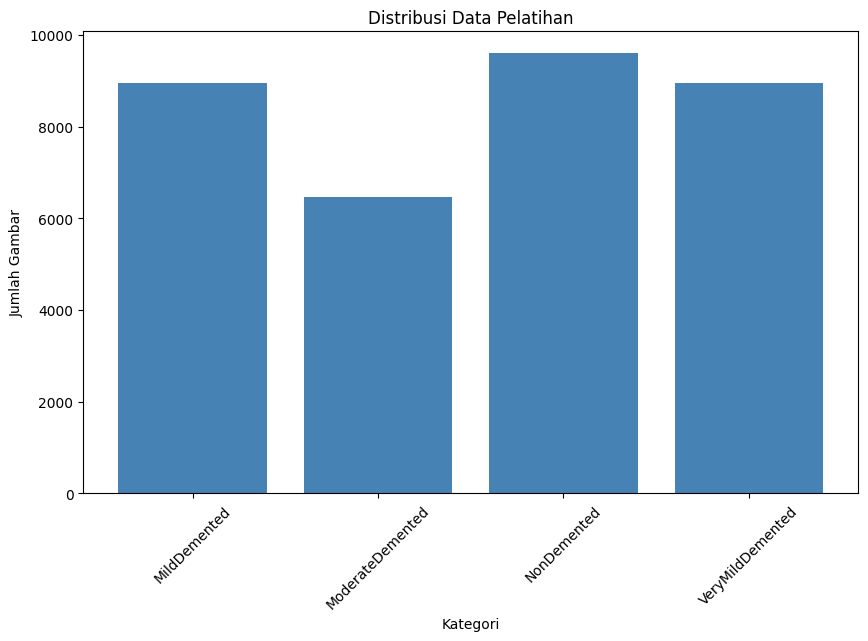

In [ ]:
# prompt: visualize train dir data distribution using bar chart

# Calculate the number of images in each category for the training data
train_counts = []
for category in CATEGORIES:
    count = len(os.listdir(os.path.join(train_dir, category)))
    train_counts.append(count)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(CATEGORIES, train_counts, color='#4682B4')
plt.xlabel('Kategori')
plt.ylabel('Jumlah Gambar')
plt.title('Distribusi Data Pelatihan')
plt.xticks(rotation=45)
plt.show()


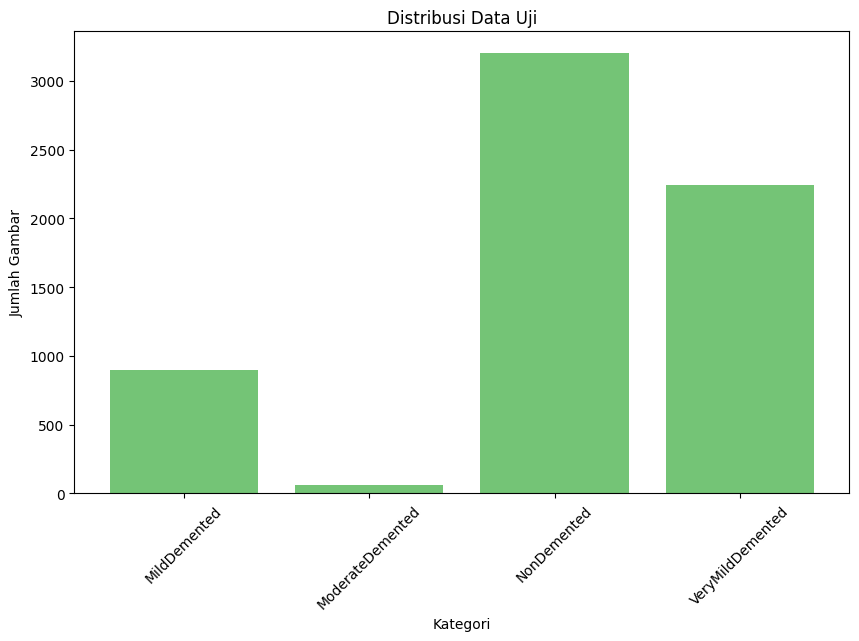

In [ ]:
# prompt: visualize train dir data distribution using bar chart

# Calculate the number of images in each category for the training data
test_counts = []
for category in CATEGORIES:
    count = len(os.listdir(os.path.join(test_dir, category)))
    test_counts.append(count)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(CATEGORIES, test_counts, color='#74C476')
plt.xlabel('Kategori')
plt.ylabel('Jumlah Gambar')
plt.title('Distribusi Data Uji')
plt.xticks(rotation=45)
plt.show()

# 4. Creating Train and Validation DataFrame

In [ ]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.shape

(33984, 3)

In [ ]:
train = train.sample(frac=1)
X = train.drop(columns = 'category_id')
y = train['category_id']

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=4)

In [ ]:
train = pd.concat([x_train, y_train], axis=1)
validation = pd.concat([x_valid, y_valid], axis=1)

In [ ]:
train = train.reset_index()
train = train.drop(columns = 'index')
validation = validation.reset_index()
validation = validation.drop(columns = 'index')
print(train.shape)
print(validation.shape)

(25488, 3)
(8496, 3)


In [ ]:
train.head()

,file,category,category_id
0,train/NonDemented/121ecd6a-e519-4f9f-bd61-dce3...,NonDemented,2
1,train/VeryMildDemented/deecd696-909f-4a86-9e90...,VeryMildDemented,3
2,train/NonDemented/875df9eb-2e77-4b29-b3f8-f5eb...,NonDemented,2
3,train/VeryMildDemented/9b9c22f5-65d2-42e8-8cac...,VeryMildDemented,3
4,train/NonDemented/8466d5f3-2d3d-44b3-bdfd-76a6...,NonDemented,2


In [ ]:
validation.head()

,file,category,category_id
0,train/VeryMildDemented/fd2ce078-a1b0-4af3-8224...,VeryMildDemented,3
1,train/MildDemented/49252cf2-27f3-45c1-82d4-be2...,MildDemented,0
2,train/ModerateDemented/0ce35616-5403-46a1-8f6c...,ModerateDemented,1
3,train/ModerateDemented/a8620392-9a83-4691-b13f...,ModerateDemented,1
4,train/ModerateDemented/a826e29a-01e8-4068-995c...,ModerateDemented,1


# 5. Creating Test DataFrame

In [ ]:
test = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(test_dir, category)):
        test.append(['val/{}/{}'.format(category, file), category_id, category])
test = pd.DataFrame(test, columns=['file', 'category_id', 'category'])
test.shape

(6400, 3)

In [ ]:
test.head()

,file,category_id,category
0,val/MildDemented/mildDem297.jpg,0,MildDemented
1,val/MildDemented/mildDem592.jpg,0,MildDemented
2,val/MildDemented/mildDem311.jpg,0,MildDemented
3,val/MildDemented/mildDem553.jpg,0,MildDemented
4,val/MildDemented/mildDem288.jpg,0,MildDemented


# 6. Demonstrating Example Images

In [ ]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

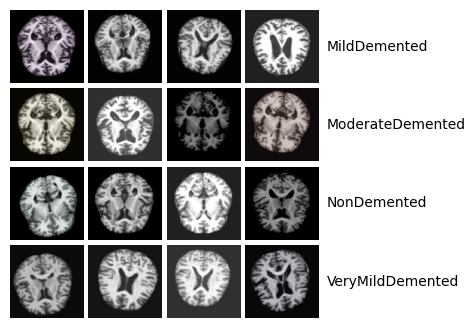

In [ ]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)

i=0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (WIDTH, HEIGHT))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i+=1

plt.show();

# 7. Keras ImageDataGenerator

In [ ]:
datagen_train = ImageDataGenerator(rescale=1./255)
train_generator = datagen_train.flow_from_dataframe(dataframe=train,
                                                  directory="/content/MRI/data",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=64,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

validation_generator = datagen_train.flow_from_dataframe(dataframe=validation,
                                                  directory="/content/MRI/data",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=64,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

Found 25488 validated image filenames belonging to 4 classes.
Found 8496 validated image filenames belonging to 4 classes.


In [ ]:
datagen_test = ImageDataGenerator(rescale=1./255)
test_generator = datagen_test.flow_from_dataframe(dataframe=test,
                                                  directory="/content/MRI/data",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=64,
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

Found 6400 validated image filenames belonging to 4 classes.


# 8. Early Stopping

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# 9. Creating Model Based on ResNet152V2

In [ ]:
#Building Model
def create_model():

    resnet_model = tf.keras.applications.resnet_v2.ResNet152V2(
        weights='imagenet',
        include_top = False,
        input_shape = (224, 224, 3)
    )

    for layers in resnet_model.layers[:100]:
        layers.trainable = False #freeze first number of layers of resnet
    for layers in resnet_model.layers[100:]:
        layers.trainable = True #unfreeze layers start from indexed number

    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    # output layer
    predictions = tf.keras.layers.Dense(4, activation='softmax')(x)

    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    # Compiling the model
    res_model.compile(loss='categorical_crossentropy', optimizer=Adamax(learning_rate = 0.001), metrics=['accuracy'])
    return res_model

In [ ]:
res_model = create_model()

In [ ]:
res_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 61,127,556 (233.18 MB)

 Trainable params: 59,186,308 (225.78 MB)

 Non-trainable params: 1,941,248 (7.41 MB)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.172832 to fit



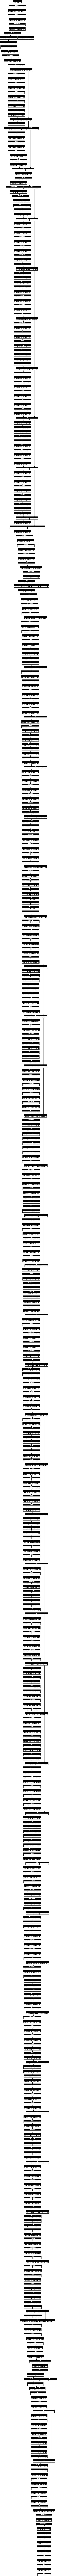

In [ ]:
# visualize model architecture
tf.keras.utils.plot_model(res_model, show_shapes=True)

# 10. Training the Model

In [ ]:
history = res_model.fit(train_generator,
                    epochs=100,
                    steps_per_epoch=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping],
                    batch_size=48)

Epoch 1/100


Plotting Model History

In [ ]:
plot_loss_curves(history)

# 10. Evaluation

In [ ]:
valid_loss, valid_accuracy = res_model.evaluate(validation_generator)

print(f'\nVTraining loss: {valid_loss:.2f}')
print(f'Training Accuracy: {valid_accuracy*100:.2f} %')

In [ ]:
loss, accuracy = res_model.evaluate(test_generator)

print(f'\nTest loss: {loss:.2f} ')
print(f'Test Accuracy: {accuracy*100:.2f} %')

In [ ]:
y_predict = res_model.predict(test_generator)
prediction = np.argmax(y_predict,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
prediction = [labels[k] for k in prediction]

y_test = list(test.category)

report = classification_report(y_test, prediction, output_dict=True)
df = pd.DataFrame(report).transpose()
df

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(5, len(acc)+5)

#Plotting training and validation accuracy graph
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

#Plotting training and validation loss graph
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [ ]:
#Test data confusion matrix
def create_classification_report(model_name):
  y_pred = model_name.predict(test_generator)
  y_pred = np.argmax(y_pred, axis=1)
  y_true = test_generator.classes

  cm = confusion_matrix(y_true, y_pred)
  class_names = list(test_generator.class_indices.keys())

  plt.figure(figsize=(8, 6), dpi=100)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  #plt.savefig('confusion_matrix.png')
  plt.show()

  report = classification_report(y_true, y_pred, target_names=class_names)
  print(report)

In [ ]:
create_classification_report(res_model)